In [2]:
import torch
from torch import nn 
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset, random_split, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score
import time

device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
root_dir_0 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0"
root_dir_1 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1"
root_dir_2 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2"

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.3517, 0.3557, 0.3570], std=[0.2325, 0.2347, 0.2353])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
#     transforms.Normalize(mean=[0.3517, 0.3557, 0.3570], std=[0.2325, 0.2347, 0.2353])
])


In [13]:
dataset_0 = datasets.ImageFolder(root=root_dir_0, transform=train_transform)
dataset_1 = datasets.ImageFolder(root=root_dir_1, transform=train_transform)
dataset_2 = datasets.ImageFolder(root=root_dir_2, transform=train_transform)


data = ConcatDataset([dataset_0, dataset_1, dataset_2])

In [32]:
dataset_0.classes

['all', 'hem']

In [14]:
train_ratio = 0.8
train_size = int(train_ratio * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

In [9]:
# class TransformDataset(torch.utils.data.Dataset):
#     def __init__(self, subset, transform=None):
#         self.subset = subset
#         self.transform = transform
        
#     def __getitem__(self, index):
#         x, y = self.subset[index]
#         if self.transform:
#             x = self.transform(x)
#         return x, y
        
#     def __len__(self):
#         return len(self.subset)


# train_data = TransformDataset(train_data, transform=train_transform)
# test_data = TransformDataset(test_data, transform=test_transform)  


In [15]:
batch_size = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


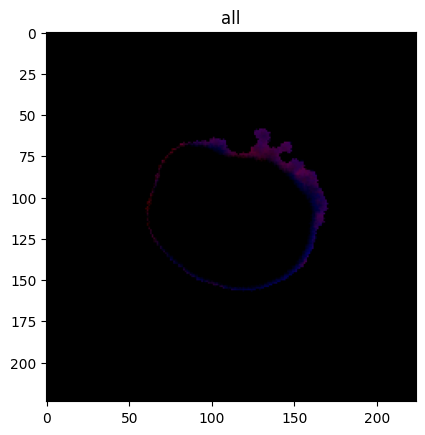

In [17]:
img, label = train_data[100]
image = np.array(img)
image = image.transpose((1, 2, 0))
plt.title(dataset_0.classes[label])
plt.imshow(image)
plt.show()

In [18]:
class CustomNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        in_features = resnet.fc.in_features
        resnet.fc = nn.Identity()
        self.trained_model = resnet
        self.flatten1 = nn.Flatten()
        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.bnorm1 = nn.BatchNorm1d(512)
        self.linear3 = nn.Linear(512, 256)
        self.bnorm2 = nn.BatchNorm1d(256)
        self.linear4 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.linear5 = nn.Linear(128, 64)
        self.bnorm3 = nn.BatchNorm1d(64)
        self.linear6 = nn.Linear(64, 32)
        self.linear7 = nn.Linear(32, 16)
        self.linear8 = nn.Linear(16, 8)
        self.linear9 = nn.Linear(8, num_classes)

    def forward(self, x):
        out = self.trained_model(x)
        out = self.linear1(out)
        out = self.dropout1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.bnorm1(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.bnorm2(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.bnorm3(out)
        out = self.linear6(out)
        out = F.relu(out)
        out = self.linear7(out)
        out = F.relu(out)
        out = self.linear8(out)
        out = F.relu(out)
        out = self.linear9(out)
        return out
        
    def predict(self, X, device='cpu'):
        X = torch.tensor(X, dtype=torch.float32).to(device)
        self.to(device)
        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)
        return y_pred.cpu().numpy()

In [20]:
custom_model = CustomNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-4)

In [21]:
def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()
        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in train_dl:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_' + name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
        print()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [22]:
history = train(custom_model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

Epoch    1  162sec	loss:      0.697	val_loss:      0.663	accuracy_score:      0.468	val_accuracy_score:      0.721	
Epoch    2   61sec	loss:      0.558	val_loss:      0.454	accuracy_score:      0.789	val_accuracy_score:      0.814	
Epoch    3   61sec	loss:      0.456	val_loss:      0.416	accuracy_score:      0.804	val_accuracy_score:      0.822	
Epoch    4   61sec	loss:      0.428	val_loss:        0.4	accuracy_score:      0.816	val_accuracy_score:      0.831	
Epoch    5   61sec	loss:      0.422	val_loss:       0.41	accuracy_score:      0.824	val_accuracy_score:      0.833	
Epoch    6   61sec	loss:      0.419	val_loss:      0.402	accuracy_score:       0.82	val_accuracy_score:      0.831	
Epoch    7   62sec	loss:      0.414	val_loss:      0.385	accuracy_score:      0.825	val_accuracy_score:      0.845	
Epoch    8   61sec	loss:      0.412	val_loss:      0.384	accuracy_score:      0.829	val_accuracy_score:      0.839	
Epoch    9   63sec	loss:      0.411	val_loss:       0.37	accuracy_score:

In [27]:
test_data[0][0]

tensor([[[-1.5127, -1.5127, -1.5127,  ..., -1.5127, -1.5127, -1.5127],
         [-1.5127, -1.5127, -1.5127,  ..., -1.5127, -1.5127, -1.5127],
         [-1.5127, -1.5127, -1.5127,  ..., -1.5127, -1.5127, -1.5127],
         ...,
         [-1.5127, -1.5127, -1.5127,  ..., -1.5127, -1.5127, -1.5127],
         [-1.5127, -1.5127, -1.5127,  ..., -1.5127, -1.5127, -1.5127],
         [-1.5127, -1.5127, -1.5127,  ..., -1.5127, -1.5127, -1.5127]],

        [[-1.5156, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156],
         [-1.5156, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156],
         [-1.5156, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156],
         ...,
         [-1.5156, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156],
         [-1.5156, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156],
         [-1.5156, -1.5156, -1.5156,  ..., -1.5156, -1.5156, -1.5156]],

        [[-1.5172, -1.5172, -1.5172,  ..., -1.5172, -1.5172, -1.5172],
         [-1.5172, -1.5172, -1.5172,  ..., -1

/tmp/ipykernel_34/511202818.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32).to(device)


[]

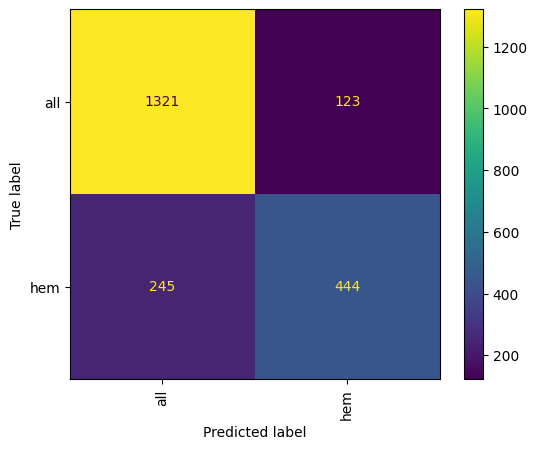

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

custom_model = custom_model.to('cpu')  

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = custom_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset_0.classes)
plt.xticks(rotation=90)
plt.plot()

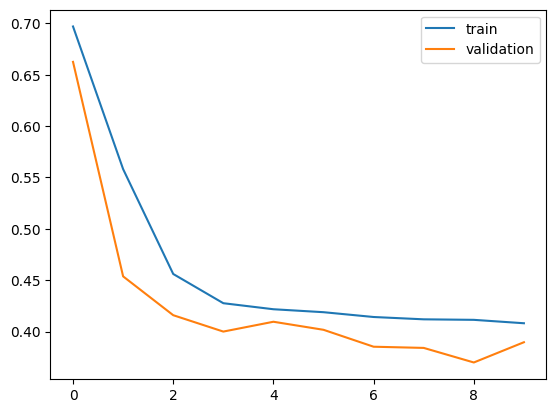

In [37]:
import matplotlib.pyplot as plt

plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="validation")
plt.legend()